In [1]:
import __init__
import torch
import matplotlib.pyplot as plt
from  math import prod

import utils.torchbox as tb
%load_ext autoreload
%autoreload 2

import metamorphosis as mt
import metamorphosis.data_cost as dc
from utils.toolbox import update_progress,format_time
from utils.constants import *

device = find_cuda()
# print(get_location())

size = (300,300)

ic| sys.path: ['/home/turtlefox/Documents/Doctorat/Demeter/examples/../demeter/',
               '/home/turtlefox/Documents/Doctorat/Demeter/examples',
               '/home/turtlefox/Documents/Doctorat/Demeter',
               '/home/turtlefox/Documents/Doctorat/Demeter/demeter',
               '/home/turtlefox/anaconda3/envs/gliomorph_env/lib/python38.zip',
               '/home/turtlefox/anaconda3/envs/gliomorph_env/lib/python3.8',
               '/home/turtlefox/anaconda3/envs/gliomorph_env/lib/python3.8/lib-dynload',
               '',
               '/home/turtlefox/anaconda3/envs/gliomorph_env/lib/python3.8/site-packages',
               '/home/turtlefox/Documents/Doctorat/Demeter']


device used : cpu


/home/turtlefox/anaconda3/envs/gliomorph_env/lib/python3.8/site-packages/torch/cuda/__init__.py:118: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


# Construct Toy-example


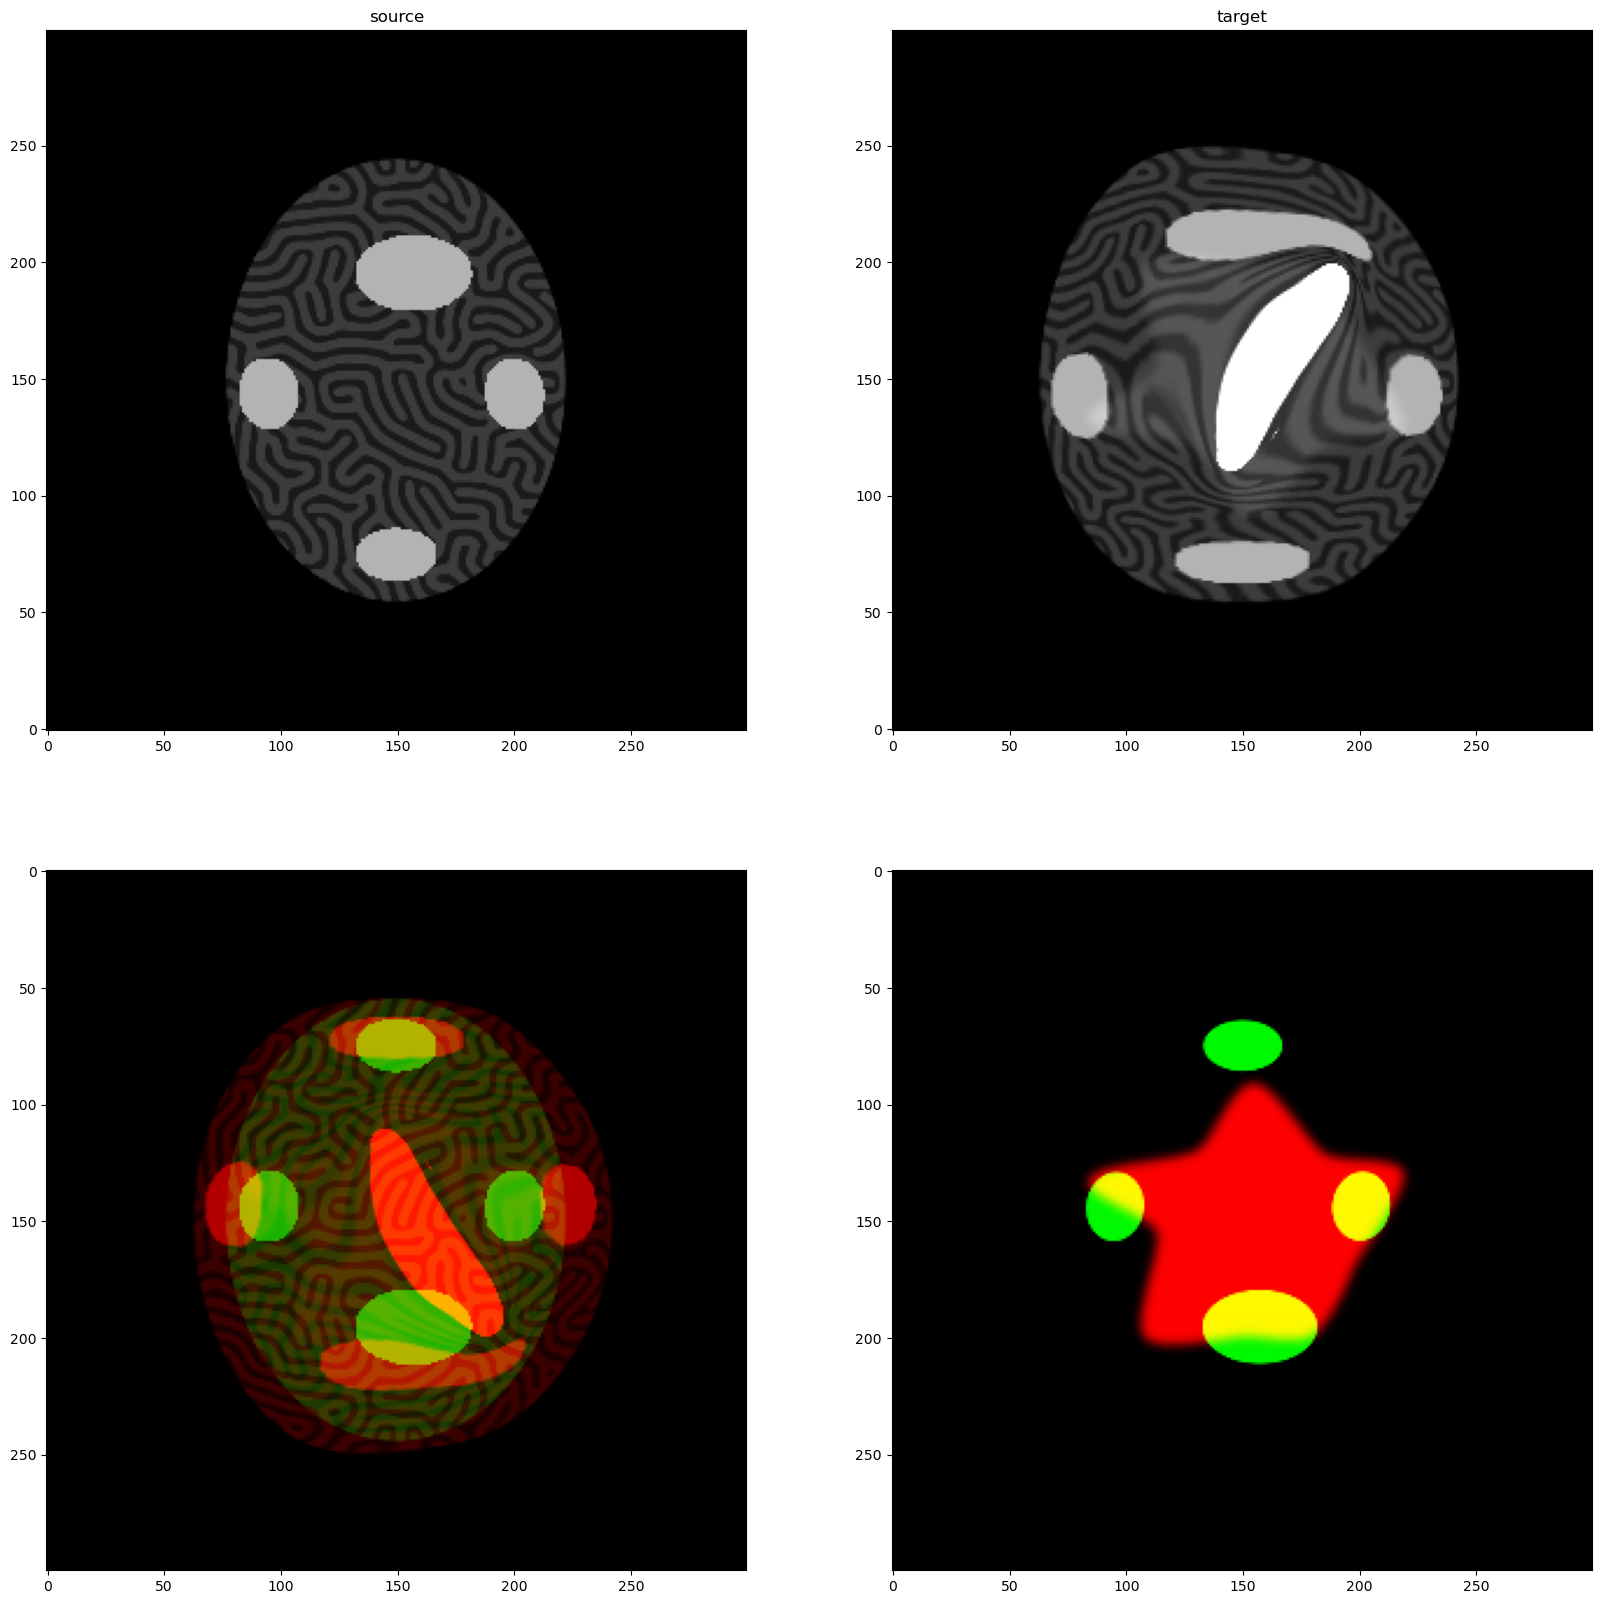

In [2]:
 
source_name,target_name = 'teGS_mbs_S','teGS_mbs_T'

S = tb.reg_open(source_name,size = size).to(device)
T = tb.reg_open(target_name,size = size).to(device)
forDice_source = tb.reg_open('te_s_v_seg',size=size)
forDice_target = tb.reg_open('teGS_mbs_segTdice',size=size)
seg_necrosis = tb.reg_open('teGS_mbs_segNec',size=size).to(device)
seg_oedeme = tb.reg_open('te_o_seg',size=size)

plt.rcParams["figure.figsize"] = (20,20)
fig,ax = plt.subplots(2,2)
ax[0,0].imshow(S[0,0].cpu(),**DLT_KW_IMAGE)
ax[0,0].set_title('source')
ax[0,1].imshow(T[0,0].cpu(),**DLT_KW_IMAGE)
ax[0,1].set_title('target')
ax[1,0].imshow(tb.imCmp(S,T),)
ax[1,1].imshow(tb.imCmp(forDice_source,seg_oedeme))
# ax[1,1].set_title('segmentation')
# ax[2,0].imshow(tb.imCmp(seg_oedeme,forDice_target))
# ax[2,1].imshow(tb.imCmp(ini_ball,seg_necrosis))
plt.show()

torch.Size([1, 1, 300, 300])
torch.Size([1, 300, 300, 2])


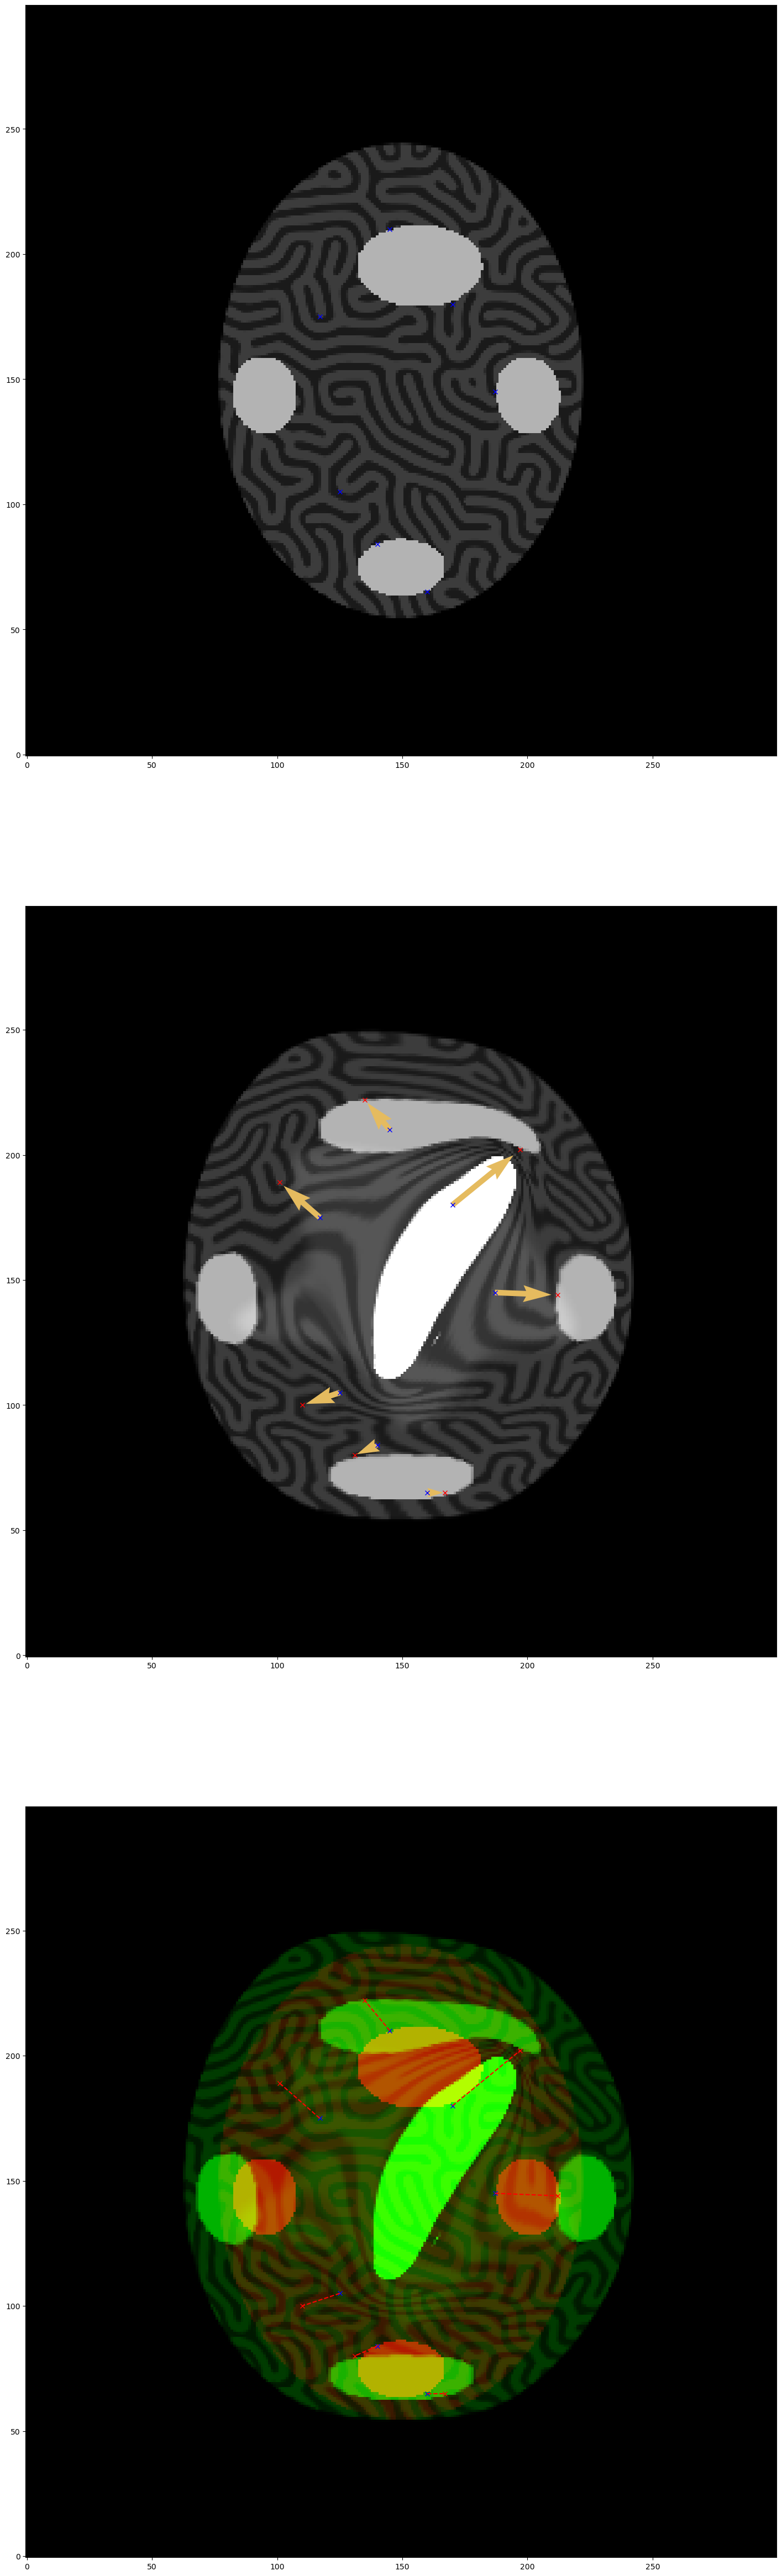

In [3]:
source_landmarks = torch.Tensor([
    [int(187),int(145)],
    [int(160),int(65)],
    [int(140),int(84)],
    [int(145),int(210)],
    [int(170),int(180)],
    [int(125),int(105)],
    [int(117),int(175)]
])
target_landmarks = torch.Tensor([
    [int(212),int(144)], # ok
    [int(167),int(65)],
    [int(131),int(80)], # ok
    [int(135),int(222)], # ok
    [int(197),int(202)], # ok
    [int(110),int(100)], # ok
    [int(101),int(189)] # ok
])

print(T.shape)
id_grid = tb.make_regular_grid(size)
print(id_grid.shape)
fig,ax = plt.subplots(3,1,figsize=(20,60))
ax[0].imshow(S[0,0].cpu(),**DLT_KW_IMAGE)
ax[0].plot(source_landmarks[:,0],source_landmarks[:,1],'x',c='blue')
ax[1].imshow(T[0,0].cpu(),**DLT_KW_IMAGE)
ax[1].plot(source_landmarks[:,0],source_landmarks[:,1],'x',c='blue')
ax[1].plot(target_landmarks[:,0],target_landmarks[:,1],'x',c='red')

ax[1].quiver(source_landmarks[:,0],source_landmarks[:,1],
             target_landmarks[:,0]-source_landmarks[:,0],
             target_landmarks[:,1]-source_landmarks[:,1],
             color= GRIDDEF_YELLOW)

ax[2].imshow(tb.imCmp(T,S),origin='lower')
ax[2].plot(source_landmarks[:,0],source_landmarks[:,1],'x',c='blue')
ax[2].plot(target_landmarks[:,0],target_landmarks[:,1],'x',c='red')
for i in range(source_landmarks.shape[0]):
    ax[2].plot([source_landmarks[i,0],target_landmarks[i,0]],
           [source_landmarks[i,1],target_landmarks[i,1]],'--',c='red')

## Make masks

centre = (tensor(167), tensor(155)), r = 5 and the seg and ball have 69 pixels overlapping
centre = (tensor(167), tensor(155)), r = 18 and the seg and ball have 772 pixels overlapping


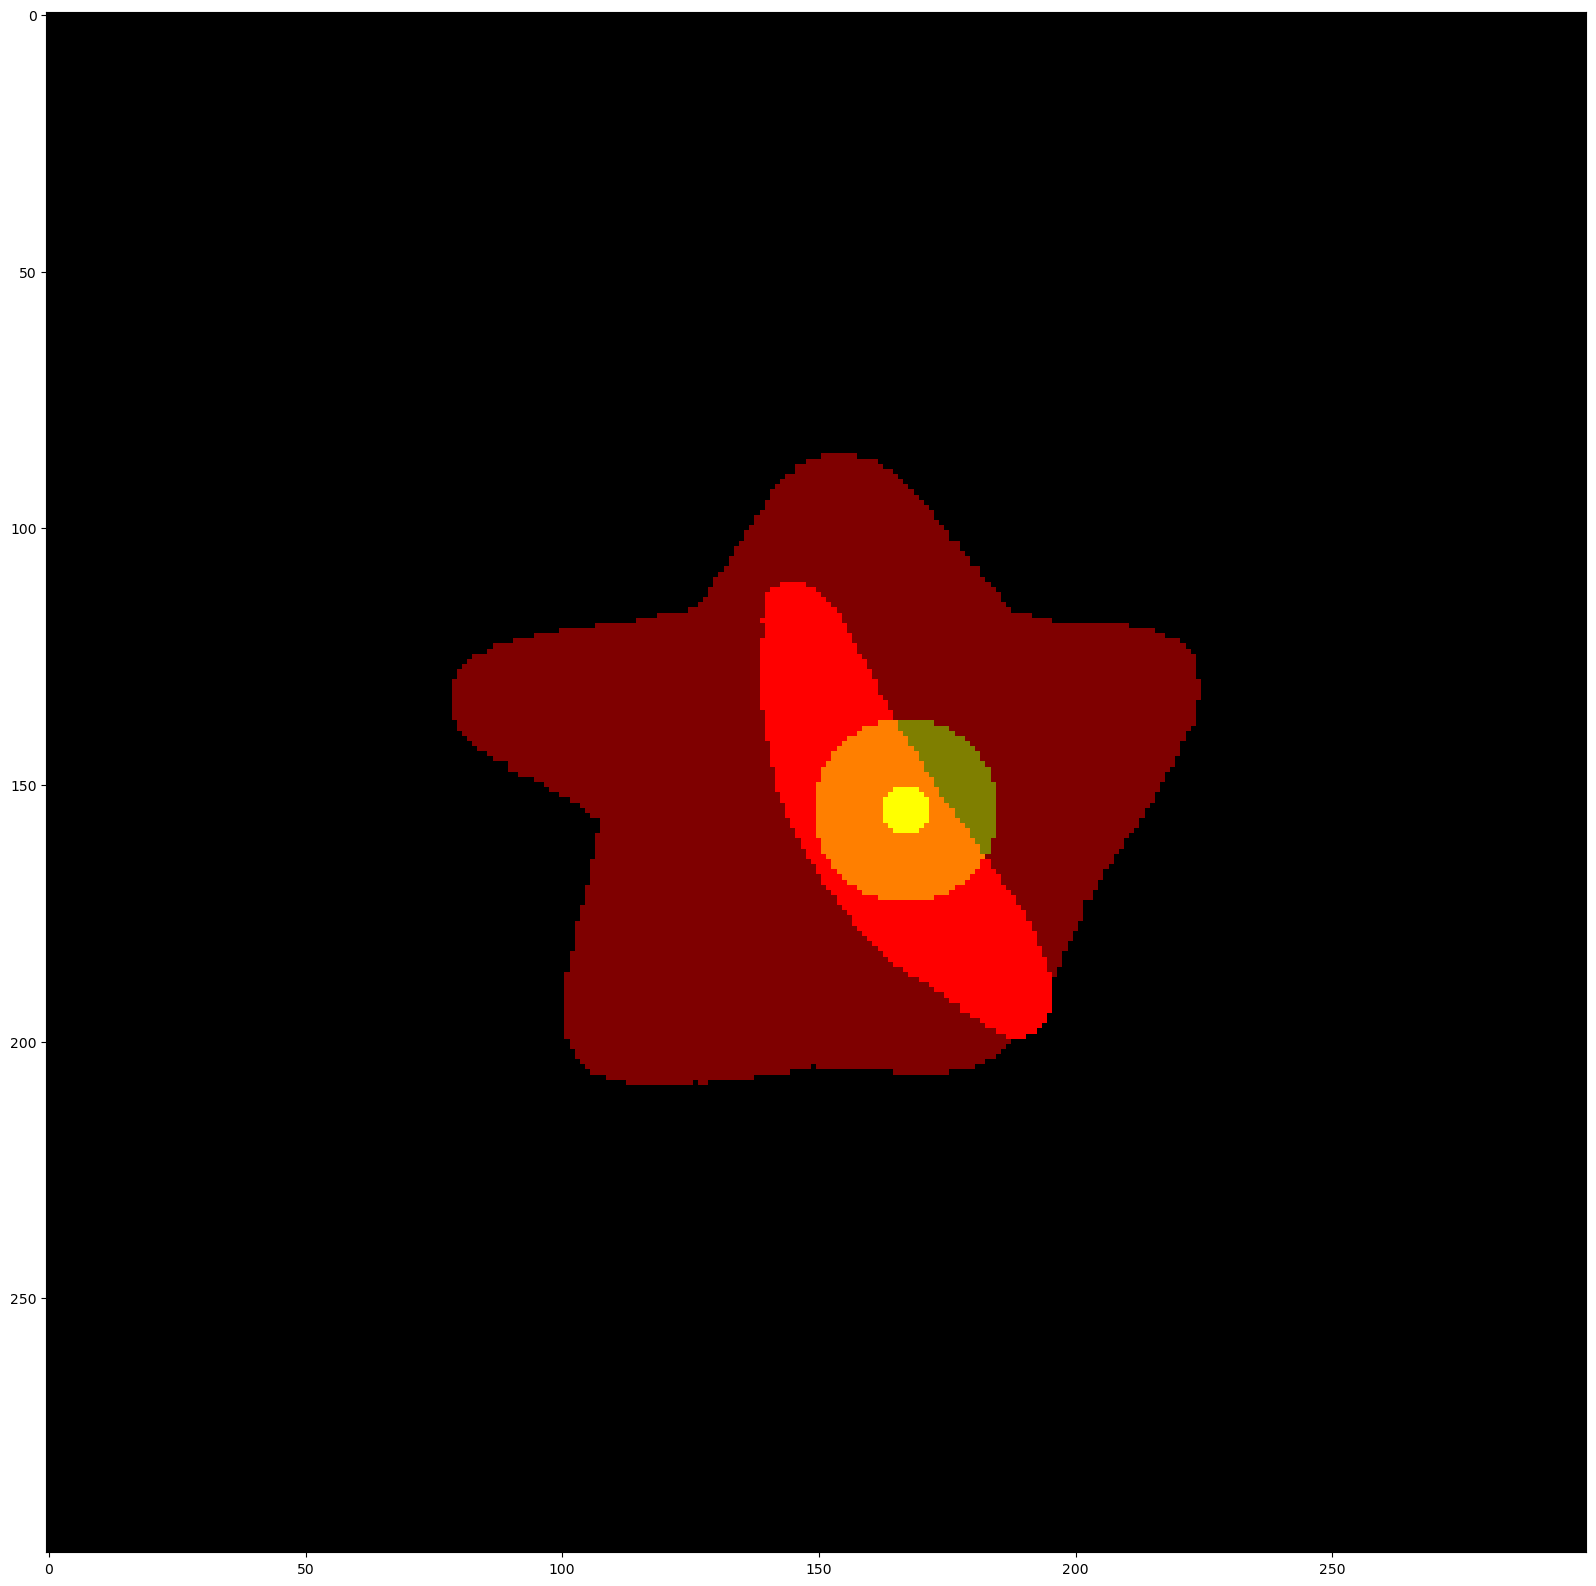

In [20]:
# make target image
val_o,val_n = .5,1
segs = torch.zeros(seg_necrosis.shape)
segs[seg_oedeme > 0] = val_o
segs[seg_necrosis > 0] = val_n
# plt.imshow(segs[0,0],vmin=0,vmax=1,cmap='gray')

# make source image
ini_ball_n,_ = tb.make_ball_at_shape_center(seg_necrosis,verbose=True,force_r=5)
ini_ball_o,_ = tb.make_ball_at_shape_center(seg_necrosis,verbose=True,force_r=18)
ini_ball_on = torch.zeros(ini_ball_o.shape)
ini_ball_on[ini_ball_o > 0] = val_o
ini_ball_on[ini_ball_n > 0] = val_n
plt.imshow(tb.imCmp(ini_ball_on,segs))


# Simple 2D

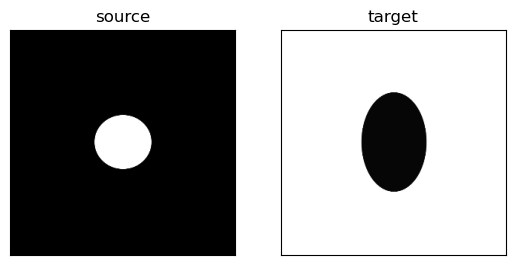

In [51]:
S = tb.reg_open('01',size=size)
T = 1 -tb.reg_open('17',size=size)

fig,ax = plt.subplots(1,2)
ax[0].imshow(S[0,0].cpu(),**DLT_KW_IMAGE)
ax[0].set_title('source')
ax[1].imshow(T[0,0].cpu(),**DLT_KW_IMAGE)
ax[1].set_title('target')
set_ticks_off(ax)
plt.show()

# LDDMM


In [52]:
data_term = dc.Mutual_Information(T,mult=10)


In [53]:
# data_term = None
resi = 0 
# resi = mr.to_analyse[0]
# resi.requires_grad = True

mr = mt.lddmm(S,T,resi,
              sigma=[10,10],
              cost_cst=.0001,
              integration_steps=5,
              n_iter=150,
              grad_coef=100,
              data_term=data_term)



MI =  0.10930800437927246


MI =  0.10930800437927246
Progress: [----------]   1.33%  (ssd :  ,   91.48).

MI =  0.1054426059126854
Progress: [----------]   2.00%  (ssd :  ,   94.84).

MI =  0.11019352078437805
Progress: [----------]   2.67%  (ssd :  ,   90.75).

MI =  0.11314842104911804
Progress: [----------]   3.33%  (ssd :  ,   88.38).

MI =  0.11799829453229904
Progress: [----------]   4.00%  (ssd :  ,   84.75).

MI =  0.1255013644695282
Progress: [----------]   4.67%  (ssd :  ,   79.68).

MI =  0.13234791159629822
Progress: [#---------]   5.33%  (ssd :  ,   75.56).

MI =  0.13767705857753754
Progress: [#---------]   6.00%  (ssd :  ,   72.63).

MI =  0.1424817144870758
Progress: [#---------]   6.67%  (ssd :  ,   70.18).

MI =  0.1478150188922882
Progress: [#---------]   7.33%  (ssd :  ,   67.65).

MI =  0.15486793220043182
Progress: [#---------]   8.00%  (ssd :  ,   64.57).

MI =  0.16148677468299866
Progress: [#---------]   8.67%  (ssd :  ,   61.92).

MI =  0.16785697638988495


data term : Mutual_Information


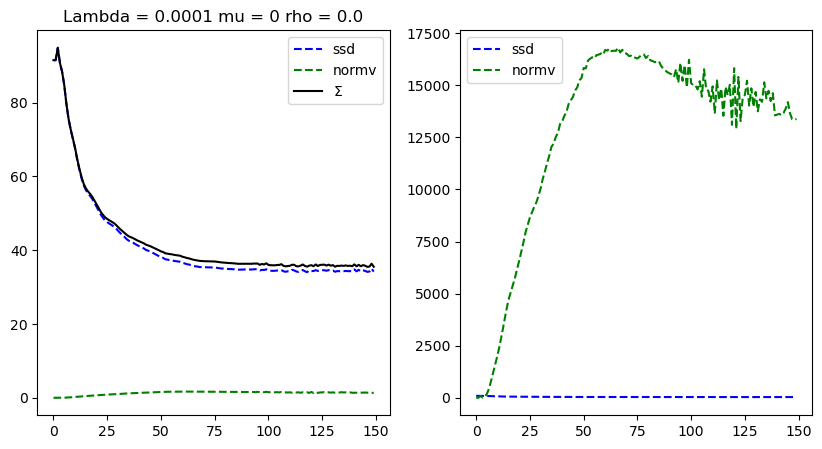

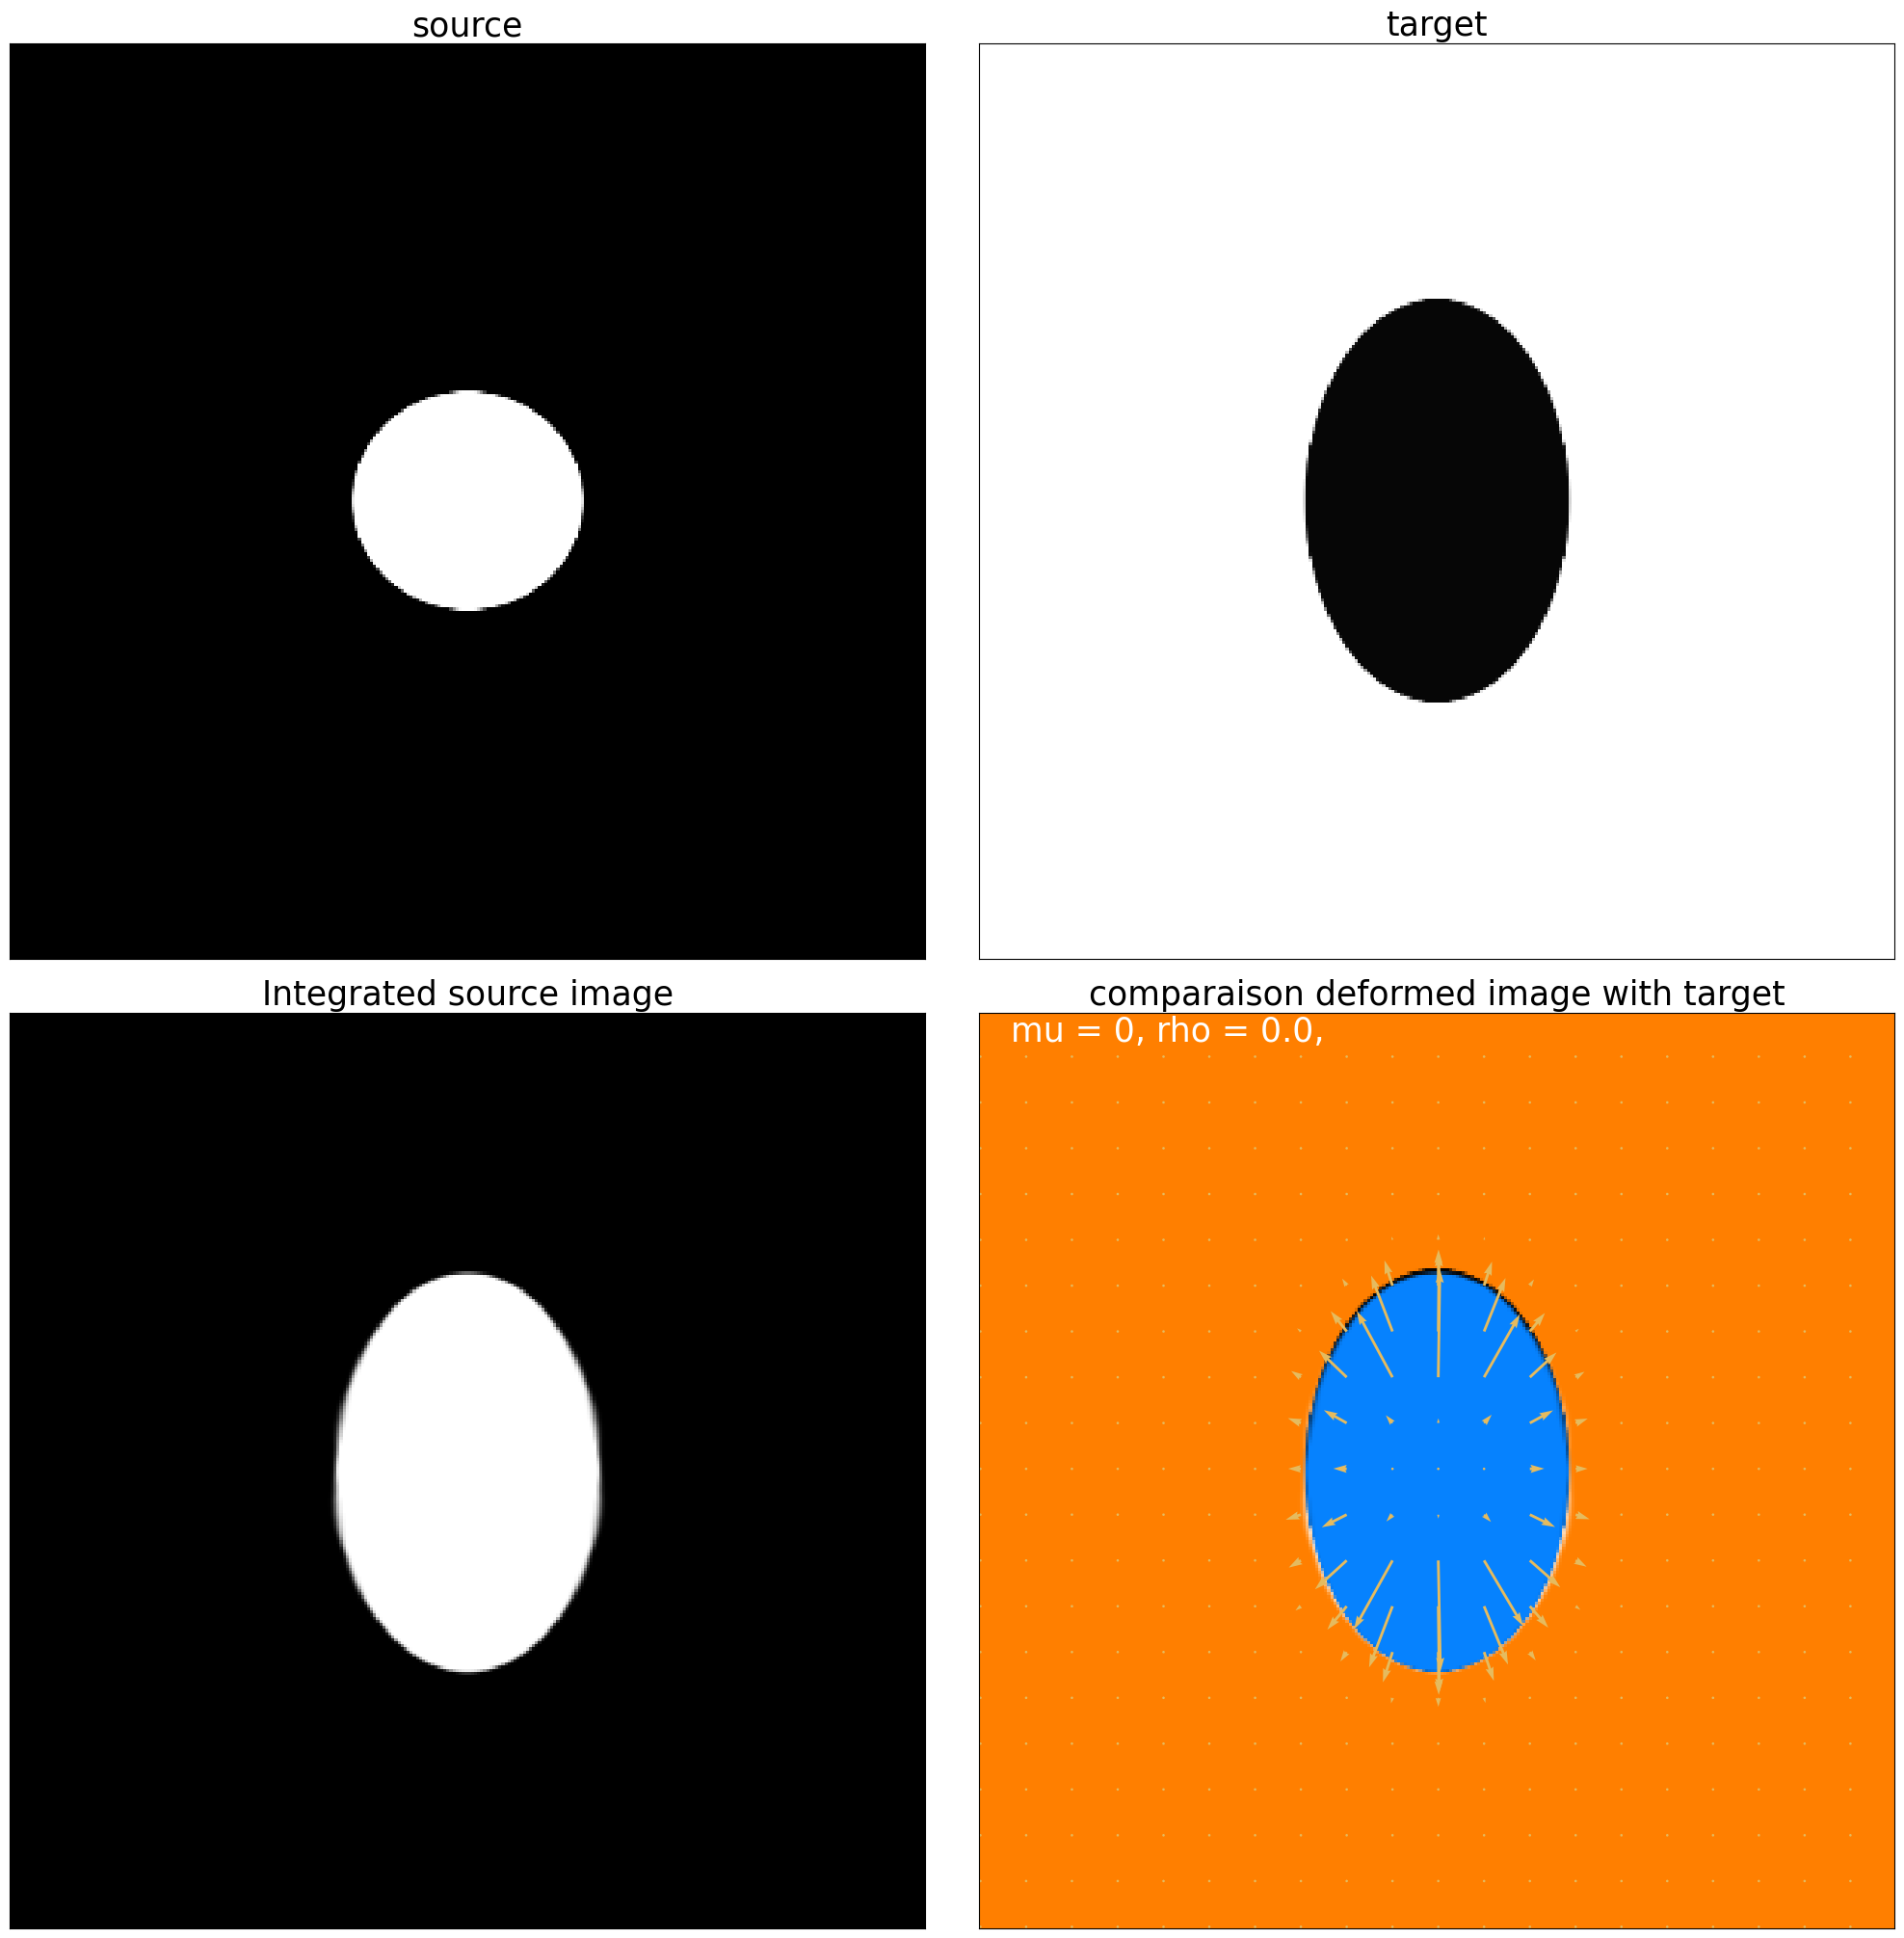

In [54]:

print("data term :", mr.data_term.__class__.__name__)
mr.plot()